- run parametric tsne
- compute metrics (training and test data)
    - silhouette
    - knn
    - trustworthiness

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'mnist'
dims = (28,28,1)

In [7]:
from tensorflow.keras.datasets import mnist

In [8]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [9]:
dims = (28,28,1)
n_components = 64

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [11]:
batch_size = 5000

In [12]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [13]:
from tfumap.parametric_tsne import compute_joint_probabilities, tsne_loss

In [14]:
P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)

Precomputing P-values...


Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.210395926597027
Minimum value of sigma: 1.1465189822400297
Maximum value of sigma: 3.423562241637291
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-

In [15]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [16]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [17]:
encoder.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [18]:
X_train = np.reshape(X_train, ([len(X_train)]+ list(dims)))
X_test = np.reshape(X_test, ([len(X_test)]+ list(dims)))

In [19]:
# because shuffle == False, the same batches are used each time...
history = encoder.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=1000)

W0720 12:08:04.866984 139774351886144 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples
Epoch 1/1000
50000/50000 [==============================] - 12s 236us/sample - loss: 4.4095
Epoch 2/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.9359
Epoch 3/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.2653
Epoch 4/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.0370
Epoch 5/1000
50000/50000 [==============================] - 1s 16us/sample - loss: 0.8855
Epoch 6/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 0.7754
Epoch 7/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.6939
Epoch 8/1000
50000/50000 [==============================] - 1s 15us/sample - loss: 0.6410
Epoch 9/1000
50000/50000 [==============================] - 1s 14us/sample - loss: 0.6040
Epoch 10/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 0.5751
Epoch 11/1000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 20us/sample - loss: 0.2530
Epoch 91/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.2497
Epoch 92/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2472
Epoch 93/1000
50000/50000 [==============================] - ETA: 0s - loss: 0.245 - 1s 18us/sample - loss: 0.2467
Epoch 94/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.2463
Epoch 95/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2494
Epoch 96/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2512
Epoch 97/1000
50000/50000 [==============================] - 1s 24us/sample - loss: 0.2528
Epoch 98/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2539
Epoch 99/1000
50000/50000 [==============================] - 1s 27us/sample - loss: 0.2531
Epoch 100/1000
50000/50000 [==============================] - 1s 25us/sample - l

50000/50000 [==============================] - 1s 19us/sample - loss: 0.2200
Epoch 180/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 0.2188
Epoch 181/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2187
Epoch 182/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2104
Epoch 183/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2058
Epoch 184/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.2018
Epoch 185/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.2006
Epoch 186/1000
50000/50000 [==============================] - 1s 23us/sample - loss: 0.2005
Epoch 187/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.2014
Epoch 188/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2053
Epoch 189/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2059
Epo

50000/50000 [==============================] - 1s 19us/sample - loss: 0.1905
Epoch 269/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1892
Epoch 270/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1883
Epoch 271/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1862
Epoch 272/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1876
Epoch 273/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1909
Epoch 274/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1938
Epoch 275/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1937
Epoch 276/1000
50000/50000 [==============================] - 1s 17us/sample - loss: 0.1916
Epoch 277/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1948
Epoch 278/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1907
Epo

50000/50000 [==============================] - 1s 20us/sample - loss: 0.1933
Epoch 358/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1998
Epoch 359/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.2018
Epoch 360/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1988
Epoch 361/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1905
Epoch 362/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1834
Epoch 363/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1850
Epoch 364/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1905
Epoch 365/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1891
Epoch 366/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1867
Epoch 367/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1869
Epo

50000/50000 [==============================] - 1s 18us/sample - loss: 0.1806
Epoch 447/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1839
Epoch 448/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1838
Epoch 449/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1788
Epoch 450/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1694
Epoch 451/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1679
Epoch 452/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1658
Epoch 453/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1603
Epoch 454/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1568
Epoch 455/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1560
Epoch 456/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1558
Epo

50000/50000 [==============================] - 1s 20us/sample - loss: 0.1740
Epoch 536/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1732
Epoch 537/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1674
Epoch 538/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1633
Epoch 539/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1604
Epoch 540/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1588
Epoch 541/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1567
Epoch 542/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1566
Epoch 543/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1647
Epoch 544/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1679
Epoch 545/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1676
Epo

50000/50000 [==============================] - 1s 22us/sample - loss: 0.1776
Epoch 625/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1775
Epoch 626/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1703
Epoch 627/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1625
Epoch 628/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1573
Epoch 629/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1507
Epoch 630/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1502
Epoch 631/1000
50000/50000 [==============================] - 1s 24us/sample - loss: 0.1531
Epoch 632/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1602
Epoch 633/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1627
Epoch 634/1000
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1652
Epo

50000/50000 [==============================] - 1s 17us/sample - loss: 0.1569
Epoch 714/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1538
Epoch 715/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1521
Epoch 716/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1572
Epoch 717/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1610
Epoch 718/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1619
Epoch 719/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1605
Epoch 720/1000
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1555
Epoch 721/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1489
Epoch 722/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1447
Epoch 723/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1435
Epo

50000/50000 [==============================] - 1s 20us/sample - loss: 0.1471
Epoch 803/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1518
Epoch 804/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1566
Epoch 805/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1582
Epoch 806/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1628
Epoch 807/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1576
Epoch 808/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1509
Epoch 809/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1466
Epoch 810/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1440
Epoch 811/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1442
Epoch 812/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1506
Epo

50000/50000 [==============================] - 1s 20us/sample - loss: 0.1511
Epoch 892/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1549
Epoch 893/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1654
Epoch 894/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1700
Epoch 895/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1704
Epoch 896/1000
50000/50000 [==============================] - 1s 18us/sample - loss: 0.1705
Epoch 897/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1700
Epoch 898/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1652
Epoch 899/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1567
Epoch 900/1000
50000/50000 [==============================] - 1s 22us/sample - loss: 0.1511
Epoch 901/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1508
Epo

50000/50000 [==============================] - 1s 21us/sample - loss: 0.1660
Epoch 981/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1588
Epoch 982/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1513
Epoch 983/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1480
Epoch 984/1000
50000/50000 [==============================] - 1s 20us/sample - loss: 0.1409
Epoch 985/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1378
Epoch 986/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1378
Epoch 987/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1408
Epoch 988/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1469
Epoch 989/1000
50000/50000 [==============================] - 1s 21us/sample - loss: 0.1498
Epoch 990/1000
50000/50000 [==============================] - 1s 19us/sample - loss: 0.1496
Epo

### get z for training and test

In [20]:
z = encoder.predict(X_train)
z_test = encoder.predict(X_test)

### Test plot

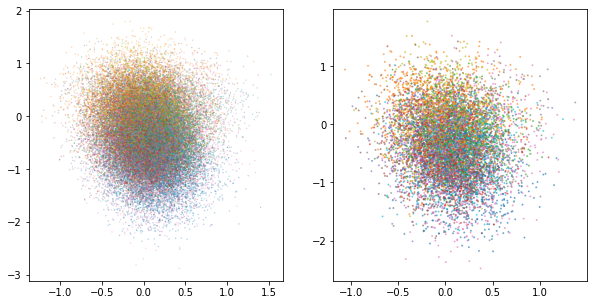

In [21]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train, cmap=plt.cm.tab10)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=Y_test, cmap=plt.cm.tab10)

### Save models + projections

In [22]:
import os

In [23]:
output_dir = MODEL_DIR/'projections'/ dataset / '64' / 'parametric-tsne'

In [24]:
encoder.save(os.path.join(output_dir, "encoder"))

W0720 12:24:59.603193 139774351886144 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0720 12:25:00.062447 139774351886144 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/parametric-tsne/encoder/assets


In [25]:
np.save(output_dir / 'z.npy', z)
np.save(output_dir / 'z_test.npy', z_test)

### compute metrics

#### silhouette

In [26]:
from tfumap.silhouette import silhouette_score_block

In [27]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.048799718161107515

In [28]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.054402503443299874

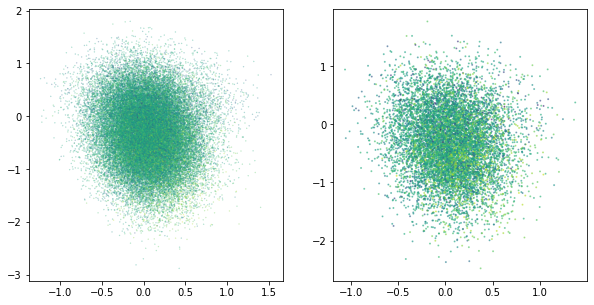

In [29]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9734

In [32]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9697

#### Trustworthiness

In [33]:
from sklearn.manifold import trustworthiness

In [34]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [35]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [36]:
tw, tw_test

(0.9996863350680545, 0.9995791873498799)

#### save output metrics

In [37]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,mnist,parametric-tsne,64,0.999686,0.0488,"[-0.010860901595925445, 0.18013561474196357, 0..."


In [38]:
save_loc = DATA_DIR / 'projection_metrics' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [39]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'parametric-tsne', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,mnist,parametric-tsne,64,0.999579,0.054403,"[0.1487975518993248, 0.0023117469795919795, 0...."


In [40]:
save_loc = DATA_DIR / 'projection_metrics' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

In [41]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['parametric-tsne', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,64,mnist,0.9697,0.9734


In [42]:
save_loc = DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)